# Compare Backtesting Trading Strategies with Seaborn

---

This notebook demonstrates how to implement and evaluate simple trading strategies using historical stock data.  
We will use **pandas** for data manipulation, **seaborn** for visualization, and **matplotlib** for plotting.

---

### Imports

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import talib
import yfinance as yf
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

c:\Users\natha\anaconda3\envs\venv\lib\site-packages\backtesting\_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

##  Strategy Implementations

---

### 1. Simple Moving Average (SMA)
Buys when the short-term average crosses up through the long-term average (golden cross). Sells when the short-term average crosses down through the long-term average (death cross).

In [5]:
class SMAcrossover(Strategy):
    display_name = "SMAcrossover"
    short = 5
    long = 10

    def init(self):
        close = self.data.Close
        self.sma_short = self.I(talib.SMA, close, self.short)
        self.sma_long = self.I(talib.SMA, close, self.long)

    def next(self):
        cross_up = crossover(self.sma_short, self.sma_long)
        cross_down = crossover(self.sma_long, self.sma_short)
        if cross_up:
            if self.position:
                self.position.close()
            self.buy()
        elif cross_down:
            if self.position:
                self.position.close()

### 2. Relative Strength Index (RSI)

Buys when the RSI shoots up above 30. Sells when the RSI drops below 70.

In [6]:
class RSI(Strategy):
    display_name = "RSI"
    timeperiod = 7
    
    def init(self):
        self.rsi = self.I(talib.RSI, self.data.Close, self.timeperiod)
    
    def next(self):
        if self.rsi[-2] < 35 and self.rsi[-1] >= 35:
            if self.position:
                self.position.close()
            self.buy()
        elif self.rsi[-2] > 65 and self.rsi[-1] <= 65:
            if self.position:
                self.position.close()

### 3. Momentum Investing

Buys when momentum is positive. Sells when momentum is negative.

In [7]:
class Momentum(Strategy):
    display_name = "Momentum"
    timeperiod = 20
    
    def init(self):
        close = self.data.Close
        self.momentum = self.I(talib.MOM, close, timeperiod=self.timeperiod)
        
    def next(self):
        if self.momentum[-1] > 0 and self.momentum[-2] <= 0:
            if self.position:
                self.position.close()
            self.buy()
        elif self.momentum[-1] < 0 and self.momentum[-2] >= 0:
            if self.position:
                self.position.close()

## Main Function

---

### Ask User for a Strategy

Provide user a list of available strategies and ask use which strategies to compare.

In [8]:
strategies = {
    'smacrossover': SMAcrossover,
    'rsi': RSI,
    'momentum': Momentum
}

while True:
    try:
        n = int(input("How many strategies would you like to compare? "))
        if n < 1:
            print("Please enter a positive integer.")
            continue
        break
    except ValueError:
        print("Invalid input. Please enter a valid integer.")

print("\nAvailable strategies:")
for strat in strategies.values():
    print(f" - {strat.display_name}")

chosen_strategies = []
for i in range(n):
    while True:
        strategy_input = input(f"\nStrategy {i + 1}: ").strip().lower()
        if strategy_input in strategies and strategy_input not in chosen_strategies:
            chosen_strategies.append(strategy_input)
            print(f"{strategies[strategy_input].display_name} added.")
            break
        else:
            print("Invalid or duplicate strategy. Try again.")


Available strategies:
 - SMAcrossover
 - RSI
 - Momentum
RSI added.
Momentum added.


### Get Data

Download data from Yahoo Finance and set necessary columns.

In [9]:
df = yf.download('AAPL', period='2y', auto_adjust=True)
df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

[*********************100%***********************]  1 of 1 completed


### Backtest the Strategies

Backtest and print the numerical results of each strategy.

In [10]:
cash, commission, margin = 1000000, 0.001, 1.0

results = {}
for strat in chosen_strategies:
    bt = Backtest(df, strategies[strat], cash=cash, commission=commission, margin=margin)
    results[strat] = bt.run()
    print(f"Results for {strategies[strat].display_name}:\n{results[strat]}\n\n")
    print(f"Number of trades: {len(results[strat]._trades)}")

C:\Users\natha\AppData\Local\Temp\ipykernel_21352\665228102.py:6: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  results[strat] = bt.run()


Results for RSI:
Start                     2023-08-09 00:00:00
End                       2025-08-08 00:00:00
Duration                    730 days 00:00:00
Exposure Time [%]                    53.58566
Equity Final [$]                1210593.72624
Equity Peak [$]                 1210593.72624
Commissions [$]                   59130.34723
Return [%]                           21.05937
Buy & Hold Return [%]                29.26879
Return (Ann.) [%]                    10.06888
Volatility (Ann.) [%]                28.22889
CAGR [%]                              6.81974
Sharpe Ratio                          0.35669
Sortino Ratio                         0.57681
Calmar Ratio                          0.36264
Alpha [%]                             0.85931
Beta                                  0.69016
Max. Drawdown [%]                    -27.7654
Avg. Drawdown [%]                   -11.33145
Max. Drawdown Duration      371 days 00:00:00
Avg. Drawdown Duration      118 days 00:00:00
# Trades         

C:\Users\natha\AppData\Local\Temp\ipykernel_21352\665228102.py:6: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  results[strat] = bt.run()


## Plot Data

---

### Plot Comparison Graph

Graph includes buy and hold equity along with chosen strategies.

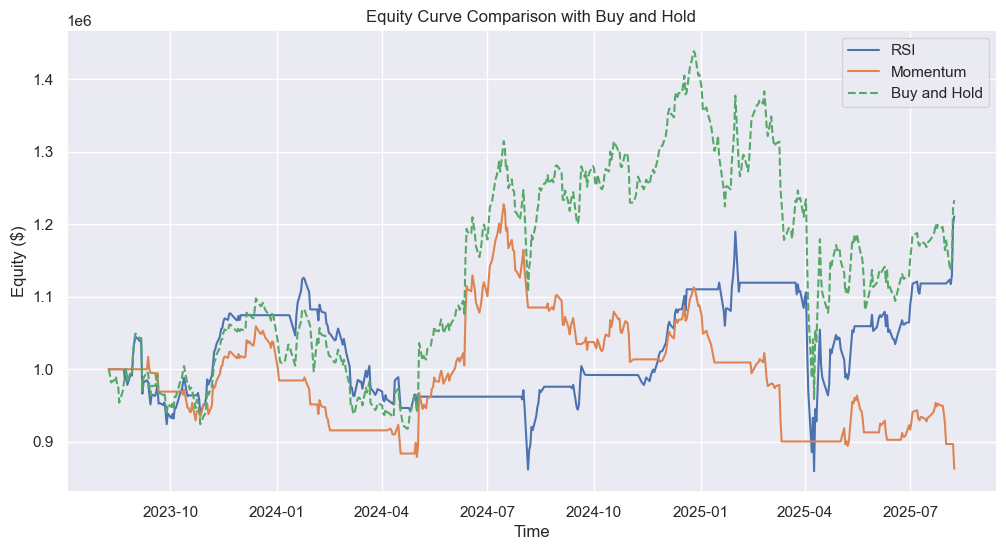

In [ ]:
buy_and_hold_equity = (df['Close'] / df['Close'].iloc[0]) * cash

sns.set_theme(style="darkgrid")

plt.figure(figsize=(12, 6))

for name, result in results.items():
    sns.lineplot(x=result._equity_curve.index, y=result._equity_curve['Equity'], label=strategies[name].display_name)
sns.lineplot(x=buy_and_hold_equity.index, y=buy_and_hold_equity.values, linestyle='--', label=f"Buy and Hold")

plt.title("Equity Curve Comparison with Buy and Hold")
plt.xlabel("Time")
plt.ylabel("Equity ($)")
plt.legend()
plt.show()

### Plot Selected Graph

In [12]:
if plot_choice in ["y", "Y", "yes", "Yes"]:
    sns.set_theme(style="darkgrid")

    plt.figure(figsize=(12, 6))

    for name, result in results.items():
        sns.lineplot(x=result._equity_curve.index, y=result._equity_curve['Equity'], label=strategies[name].display_name)
    sns.lineplot(x=buy_and_hold_equity.index, y=buy_and_hold_equity.values, linestyle='--', label=f"Buy and Hold")

    plt.title("Equity Curve Comparison with Buy and Hold")
    plt.xlabel("Time")
    plt.ylabel("Equity ($)")
    plt.legend()
    plt.show()
elif plot_choice in ["n", "N", "no", "No"]:
    bt.plot()